In [24]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import math
import random
import pandas as pd
import seaborn as sns
from __future__ import division
import time
from distutils.log import error
import errno
from datetime import date
import pyomo.environ as pyo
import parameters
from pyomo.environ import *
%matplotlib inline

import sys, os
from IPython.display import display


In [142]:
def solar(lat,lon,TimeZone):
    
    if TimeZone == 'Eastern':
        LocalMeridian = 75
    elif (TimeZone == 'Central'):
        LocalMeridian = 90
    elif (TimeZone == 'Mountain'):
        LocalMeridian = 105
    elif (TimeZone == 'Pacific'):
        LocalMeridian = 120
        
    JulianDay = np.arange(206,207,2)
    LonCor = np.zeros(len(JulianDay))
    Eq_Time = np.zeros(len(JulianDay))
    SolarNoon = np.zeros(len(JulianDay))
    ApparentSolar = np.zeros(len(JulianDay))
    SolarDec = np.zeros(len(JulianDay))
    OpticalDepth = np.zeros(len(JulianDay))
    SkyDiff = np.zeros(len(JulianDay))
    SolarAltNoon = np.zeros(len(JulianDay))
    AMRNoon = np.zeros(len(JulianDay))
    
    for i in range(len(JulianDay)):
        LonCor[i] = (360/364*(JulianDay-81))
        Eq_Time[i] =(9.87*np.sin(np.radians(2*LonCor[i])))-(7.53*np.cos(np.radians(LonCor[i])))-(1.5*np.sin(np.radians(LonCor[i])))
        SolarNoon[i] = ((12*60)-4*(LocalMeridian-lon)-Eq_Time[i])/60 + 1
        ApparentSolar[i] = 1160+75*np.sin(np.radians((360/365)*(JulianDay[i]-275)))
        SolarDec[i] = 23.45*np.sin(np.radians(360/365*(JulianDay[i]-81)))
        OpticalDepth[i] = 0.174+0.035*np.sin(np.radians(360/365*(JulianDay[i]-100)))
        SkyDiff[i] = 0.095 + 0.04*np.sin(np.radians(360/365*(JulianDay[i]-100)))
        SolarAltNoon[i] = np.degrees(np.arcsin(np.cos(np.radians(lat))*np.cos(np.radians(SolarDec[i]))+np.sin(np.radians(lat))*np.sin(np.radians(SolarDec[i]))))
        AMRNoon[i] = abs(1/np.sin(np.radians(SolarAltNoon[i])))
    
    Time = np.linspace(0,24,24*4)
    SolarTime = np.zeros((len(Time),len(JulianDay)))
    HoursAfterNoon = np.zeros((len(Time),len(JulianDay)))
    SolarAlt = np.zeros((len(Time),len(JulianDay)))
    AMR = np.zeros((len(Time),len(JulianDay)))
    ClearSky = np.zeros((len(Time),len(JulianDay)))
    Angle = np.zeros((len(Time),len(JulianDay)))
    Irradiance = np.zeros((len(Time),len(JulianDay)))
    
    for i in range(len(JulianDay)):
        for j in range(len(Time)):
            SolarTime[j,i] = ((Time[j]*60+4*np.radians(LocalMeridian-lon)+Eq_Time[i])/60)-1
            HoursAfterNoon[j,i] = SolarNoon - Time[j]
            SolarAlt[j,i] = np.degrees(np.arcsin(np.cos(np.radians(lat))*np.cos(np.radians(SolarDec[i]))*np.cos(np.radians(15*HoursAfterNoon[j,i]))+np.sin(np.radians(lat))*np.sin(np.radians(SolarDec[i]))))
            AMR[j,i] = abs(1/np.sin(np.radians(SolarAlt[j,i])))
            if (SolarAlt[j,i] >0):
                ClearSky[j,i] = ApparentSolar[i]*np.exp(-OpticalDepth[i]*AMR[j,i])
            else:
                ClearSky[j,i] = 0
            Angle[j,i] = np.sin(np.radians(SolarAlt[j,i]))
            Irradiance[j,i] = ClearSky[j,i]*(Angle[j,i]+SkyDiff[i])
                                          
    
    
    return SolarAlt


# solar(51,122.272743,'Pacific')
    
    
    
    
    
    
    

In [143]:
User_PV_Data = pd.read_csv('./Solar_Demand_1.csv')

# get_all_values gives a list of rows.


userdata = np.array(User_PV_Data.values)


print(User_PV_Data)


     Time  PV_Output  PV_Percentage  Demand_kW  Grid_Cost
0    0:00        0.0            0.0       0.12       0.01
1    0:15        0.0            0.0       0.12       0.01
2    0:30        0.0            0.0       0.12       0.01
3    0:45        0.0            0.0       0.12       0.01
4    1:00        0.0            0.0       0.16       0.01
..    ...        ...            ...        ...        ...
91  22:45        0.0            0.0       0.20       0.01
92  23:00        0.0            0.0       0.16       0.01
93  23:15        0.0            0.0       0.16       0.01
94  23:30        0.0            0.0       0.16       0.01
95  23:45        0.0            0.0       0.16       0.01

[96 rows x 5 columns]


In [144]:
prof=pd.Series(dtype='object')

prof.loc['Time']=User_PV_Data.iloc[:,0]
prof.loc['Solar']=User_PV_Data.iloc[:, 1]
# prof.loc['SolarPerc']=User_PV_Data.iloc[:,2]
prof.loc['Load']=User_PV_Data.iloc[:, 3]
prof.loc['Price']=User_PV_Data.iloc[:, 4]
max_solar = max(User.Solar)
prof.SolarPerc = User.Solar/max_solar

# User.to_numpy()

# User,User.shape

prof.Solar.shape

(96,)

In [148]:
net = prof.Load-prof.Solar
# split load into +ve and -ve
posLoad = np.copy(net)
negLoad = np.copy(net)
for j,e in enumerate(net):
    if e>=0:
        negLoad[j]=0
    else:
        posLoad[j]=0
posLoadDict = dict(enumerate(posLoad))
negLoadDict = dict(enumerate(negLoad))

In [200]:
def microgrid(Nbmax,Npmax):
    
    model = ConcreteModel()
     # Time
    T = np.shape(prof.Time)[0]
    model.k = RangeSet(0,T-1)
    
    # Scalar Parameters
    model.Cgi = Param(initialize=0.1990) #average cost of electricity in California ($/kWh)
    model.Cs = Param(initialize=0.08) #average cost of solar in US ($/kWh)
    model.Cb = Param(initialize=135) #predicted cost of battery in 2022 ($/kWh)
    model.Cge = Param(initialize=0.03) #PGE average sell to grid rate ($/kWh)
    model.eta_bd = Param(initialize=0.95) #discharging efficiency
    model.r = Param(initialize=0.004) # Real interest rate
    model.b_min = Param(initialize=0)
    model.MaxPanels = Param(initialize=Npmax//1.6) #Max Allowed Solar Panels (m2/m2)
    
    
    # Indexed Parameters
    model.Time = Param(model.k,initialize=dict(enumerate(prof.Time,0)))
    model.Solar = Param(model.k,initialize=dict(enumerate(prof.Solar,0)))
    model.SolarPerc = Param(model.k,initialize=dict(enumerate(prof.SolarPerc,0)))
    model.Load = Param(model.k,initialize=dict(enumerate(prof.Load,0)))
   
    # Variables
    model.Np = Var(within=NonNegativeReals,bounds = (0,1.5*model.MaxPanels),initialize=1.5*model.MaxPanels) #Solar Capacity (kWh)
    model.Nb = Var(within=NonNegativeReals,bounds=(0,Nbmax),initialize=Nbmax) #Battery Capacity (kWh)
    model.SOC = Var(model.k, within=NonNegativeReals, bounds=(0,Nbmax),initialize=Nbmax) #Battery SOC (kWh)
    model.Bc = Var(model.k, within=NonNegativeReals, initialize=0) #Battery Charge (kWh)
    model.Bd = Var(model.k, within=NonNegativeReals,initialize=0) #Batttery Discharge (kWh)
    model.Ge = Var(model.k, within=NonNegativeReals, initialize=0) #Sell to grid (kWh)
    model.Gi = Var(model.k, within=NonNegativeReals,initialize = 0)  #Take from grid (kWh)
    model.C = Var(model.k, within=NonNegativeReals,initialize=model.Load[0]) #Supplied to Demand (kWh)
    
    #Objective
    def ObjF(model):
        return sum(model.Cgi*model.Gi[k] + model.Cs*model.Np + model.Cb*model.Nb - model.Cge*model.Ge[k] for k in model.k)
    model.Cost = Objective(rule=ObjF)

    #Constraints
    def TotalBalance(model,k):
        return (model.Np*model.SolarPerc[k] + model.Gi[k] + model.Bd[k] == model.Ge[k] + model.Bc[k] + model.C[k])
    model.TotalBalance = Constraint(model.k,rule=TotalBalance)
    
#     def TakeGridBalance(model,k):
#         return 0<=model.Gi[k]<=(model.Np*model.SolarPerc[k]+model.Bd[k]
#     model.TakeGridBalance = Constraint(model.k,rule=TakeGridBalance)
    
#     def GiveGridBalance(model,k):
#         return (0,model.Ge[k],(model.Load[k]+model.Bc[k]))
#     model.GiveGridBalance = Constraint(model.k,rule=GiveGridBalance)
    
#     def Charge(model,k):
#         model.SOC[0] == model.Nb
#         return (0<=model.SOC[k]<=model.Nb)
#     model.Charge = Constraint(model.k,rule=Charge)
    
    def SOCBalance(model,k):
        model.SOC[0] == model.Nb
        if k<=T-2:
            return (model.SOC[k+1] == model.SOC[k] + model.Bc[k] - model.eta_bd*model.Bd[k])
        else:
            return (model.SOC[k]== model.SOC[k] + model.Bc[k] - model.eta_bd*model.Bd[k])
    
    model.SOCBalance = Constraint(model.k,rule=SOCBalance)

    def DeltaB(model,k):
        if k<T-2:
            return (None,model.SOC[k+1]-model.SOC[k],model.Nb/4)
        else:
            return (None,model.SOC[k],-model.Nb/4)
    model.DeltaB = Constraint(model.k,rule=DeltaB)

    def LoadBalance(model,k):
        return (None, model.Load[k],model.C[k])
    model.LoadBalance = Constraint(model.k,rule=LoadBalance)
    
    
    #Solve
    solver = SolverFactory('glpk')
    results = solver.solve(model)
    
# Final Values
    Time = np.zeros((T,1))
    Time = np.arange(0,T,1)
    Load = np.zeros((T,1))
    Price = np.zeros((T,1))
    Solar_Obtained = np.zeros((T,1))
    SOC = np.zeros((T,1))
    Bc = np.zeros((T,1))
    Bd = np.zeros((T,1))
    Gi = np.zeros((T,1))
    Ge = np.zeros((T,1))
    
    for k in range(len(model.k)):
        Load[k] = value(model.Load[k])
        Price[k] = value(model.Cgi)*value(model.Gi[k])+value(model.Cs)*value(model.Np)+value(model.Cb)*value(model.Np)-value(model.Cge)*value(model.Ge[k])
        if value(model.Np)*value(model.Solar[k])<=value(model.Load[k]):
            Solar_Obtained[k] = value(model.Np)*value(model.Solar[k])
        elif value(model.Np)*value(model.Solar[k])>value(model.Load[k]):
            Solar_Obtained[k] = value(model.Load[k])
        SOC[k] = value(model.SOC[k])
        Bc[k] = value(model.Bc[k])
        Bd[k] = value(model.Bd[k])
        Gi[k] = value(model.Gi[k])
        Ge[k] = value(model.Ge[k])
    
# Plot 
    
    plt.plot(Time,Load)
    plt.plot(Time,Solar_Obtained)
    plt.plot(Time,SOC)
    plt.plot(Time,Gi)
    plt.plot(Time,Ge)
    plt.legend(['Load','Solar','SOC','Gi','Ge'])
    plt.figure(figsize = (100,100))

#     out = pd.DataFrame(dtype='object')
#     out.loc[:,'Load'] = Load
#     out.loc[:,'Price'] = Price
#     out.loc[:,'Solar Obtained'] = Solar_Obtained
#     out.loc[:,'SOC'] = SOC
#     out.loc[:,'Bc'] = Bc
#     out.loc[:,'Bd'] = Bd
#     out.loc[:,'Gi'] = Gi
#     out.loc[:,'Ge'] = Ge
#     out = out.round(2)
    out = value(model.Np),value(model.Nb)
    return out


(936.0, 10)

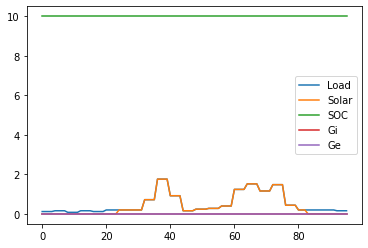

<Figure size 7200x7200 with 0 Axes>

In [201]:
microgrid(10,1000)
# plt.plot(out[0],out[1])

In [16]:
# IGNORE ---------------------------------


def microgrid(parameters,User,Npmax):
    model = ConcreteModel()

    #Max Area
    MaxArea = Npmax//1.6 #Max Allowed Solar Panels (m2/m2)
    
    # Time
    T = np.shape(User.Time)[0]
    k_data = { idx:item for idx, item in enumerate(np.arange(0, 68, 0.5))}
    model.k = RangeSet(0,T)
    
    # Variables
    model.SOC = Var(model.k, domain=NonNegativeReals) #Battery SOC (kWh)
    model.Bc = Var(model.k, domain=NonNegativeReals) #Battery Charge (kWh)
    model.Bd = Var(model.k, domain=NonNegativeReals) #Batttery Discharge (kWh)
    model.W = Var(model.k, domain=NonNegativeReals) #Sell to grid (kWh)
    model.P = Var(model.k, domain=NonNegativeReals) #Take from grid (kWh)
    model.C = Var(model.k, domain=NonNegativeReals) #Supplied to Demand (kWh)
    model.Np = Var(domain=NonNegativeReals) #Solar Capacity (kWh)
    model.Nb = Var(domain=NonNegativeReals) #Battery Capacity (kWh)
    
    #Objective
    def ObjF(cost):
        return sum(parameters.Cp*model.P + parameters.Cs*model.Np + parameters.Cb*model.Nb - parameters.Sw*model.W)
    model.Cost = Objective(rule=ObjF)
#     model.Cost = Objective(expr = sum(parameters.Cp*model.P[k] + parameters.Cs*model.Ts + parameters.Cb*model.Tb-parameters.Sw*model.W[k] for k in model.k))
    
    #Constraints
    def TotalBalance(model,i):
        return (model.Np*User.Solar + model.P[i] + model.Bd[i] == model.W[i] + model.Bc[i] + model.C[i])
    model.TotalBalance = Constraint(model.k,rule=TotalBalance)
#     model.TotalBalance = Constraint(model.k, rule = lambda model, k: model.Ts*User.Solar + model.P[k] + model.Bd[k] == model.W[k] + model.Bc[k] + model.C[k])
    
    def GridBalance(model,i):
        return 0<=model.P[i]<=model.Ts*User.Solar+model.Bd[i]
    model.GridBalance = Constraint(model.k,rule=GridBalance)
    
    def SOCBalance(model,i):
        return model.SOC[i+1] == model.SOC[i] + model.Bc[i] - parameters.eta_bd*model.Bd[i]
    model.SOCBalance = Constraint(model.k,rule=SOCBalance)

    def Charge(model,i):
        return 0<=model.SOC[i]<=model.Nb[i]
    model.Charge = Constraint(model.k,rule=Charge)

    def DeltaB(model,i):
        return -Nb/4<=SOC[i+1]-SOC[i]<=-Nb/4
    model.DeltaB = Constraint(model.k,rule=DeltaB)

    def InitialB(model):
        return SOC[0] == Nb
    model.InitialB = Constraint(model.k,rule=InitialB)

    def LoadBalance(model,i):
        return model.C[i]>=User.Load[i]
    model.LoadBalance = Constraint(model.k,rule=LoadBalance)
    
    def Solar(model):
        return 0<=model.Np<=1.5*MaxArea #1.5kWh/Panel
    model.InitialS = Constraint(model.k,rule=Solar)
    
    def Charge(model):
        return model.Nb>=0
    model.InitialC = Constraint(model.k,rule=Charge)


    #Solve
    solver = SolverFactory('glpk')
    results = solver.solve(model)

    output = value(model.Ts),value.model(Tb)
    
    
    return output

# Parameters
parameters = pd.Series(dtype='object')
parameters.loc['Cp'] = 0.1990 #average cost of electricity in California ($/kWh)
parameters.loc['Cs'] = 0.08 #average cost of solar in US ($/kWh)
parameters.loc['Cb'] = 135 #predicted cost of battery in 2022 ($/kWh)
parameters.loc['Sw'] = 0.03 #PGE average sell to grid rate ($/kWh)
parameters.loc['etc_bd'] = 0.95 #discharging efficiency